In [6]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

def labeltoint(label):
    if label == 'left':
        label = 0
    if label == 'keep':
        label = 1
    if label == 'right':
        label = 2
    return label


import json
import numpy as np

with open('data1/train.json', 'r') as f:
    j = json.load(f)
  #  print(j.keys())
    X_train = j['states']
    Y_train = j['labels']
    for i in range(len(Y_train)):
        Y_train[i] = labeltoint(Y_train[i])
  #  print(Y_train)

with open('data1/test.json', 'r') as f:
    j = json.load(f)
    X_test = j['states']
    Y_test = j['labels']
    for i in range(len(Y_test)):
        Y_test[i] = labeltoint(Y_test[i])

split_frac = 0.8
X_train, Y_train, X_test, Y_test = np.array(X_train).astype(np.float32), np.array(Y_train).astype(np.long), np.array(
    X_test).astype(np.float32), np.array(Y_test).astype(np.long)
## split data into training, validation, and test data (features and labels, x and y)
val_x, test_x = X_test[:len(X_test) // 2], X_test[len(X_test) // 2:]
val_y, test_y = Y_test[:len(Y_test) // 2], Y_test[len(Y_test) // 2:]

import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy((X_train)), torch.from_numpy(Y_train))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 64

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.n_layers = n_layers
        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=0, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim,hidden_dim*2)
        self.fc = nn.Linear(hidden_dim*2, output_size)
        self.fc2 = nn.Linear(X_train.shape[1],output_size)
       # self.softmax = nn.Softmax(dim=1)
    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.lstm(x, hidden)
        """
        r_out = torch.mean(r_out,dim=2).squeeze()
        
        output= self.fc2(r_out)
        # shape output to be (batch_size*seq_length, hidden_dim)
        """
        r_out = r_out.contiguous().view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc1(r_out)
        output = self.fc(output)
        output = output.view(batch_size,-1,3)
        output = output[:,-1]
       # output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

if torch.cuda.is_available():
    train_on_gpu = True
else:
    train_on_gpu = False


# In[8]:


In [8]:
def train(net,epochs,train_loader,valid_loader,clip,lr = 0.0002):
    # train for some number of epochs
    # loss and optimization functions

    loss_min = np.inf
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    counter = 0
    losses_train = []
    losses_valid = []
    accuracies_e = []
    for e in range(epochs):
        # initialize hidden state
        net.train()
        # batch loop
        train_loss = []
        for inputs, labels in train_loader:
            h = net.init_hidden(inputs.shape[0])
            h = tuple([each.data for each in h])
            inputs = inputs.unsqueeze(2)
            if (train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            # zero accumulated gradients
            net.zero_grad()
            # get the output from the model
            # print(inputs)
            output, h = net(inputs, h)

            # calculate the loss and perform backprop
          #  print(output.shape,labels.shape)
           # print(output[:1])
            loss = criterion(output, labels)
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
            train_loss.append(loss.item())
            # loss stats
                # Get validation loss

        val_losses = []
        net.eval()
        accuracies = []
        for inputs, labels in valid_loader:
            val_h = net.init_hidden(inputs.shape[0])
            inputs = inputs.unsqueeze(2)
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                   # val_h = tuple([each.data for each in val_h])
            val_h = tuple([each.data for each in val_h])
            if (train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()

            output, val_h = net(inputs, val_h)

            val_loss = criterion(output, labels)
            _, class_ = torch.max(output, dim=1)
            equal = class_ == labels.view(class_.shape)
            accuracy = torch.mean(equal.type(torch.FloatTensor)).item()
            val_losses.append(val_loss.item())
            accuracies.append(accuracy)
                

        net.train()
        losses_train.append(np.mean(train_loss))
        losses_valid.append(np.mean(val_losses))
        accuracies_e.append(np.mean(np.mean(accuracies)))
        print("Epoch: {}/{}...".format(e + 1, epochs),
                      "Loss: {}...".format(np.mean(train_loss)),
                      "Val Loss: {}...".format(np.mean(val_losses)),
                      "val accuracy:{}.".format(np.mean(accuracies))
                     )
        if np.mean(val_losses) < loss_min:
            print('Val loss decreased...')
            torch.save(net.state_dict(),'model/lstm_behavior_prediction_old.pt')
            loss_min = np.mean(val_losses)
    print('min loss',loss_min)
   # plt.plot(losses_train,color='r',label='train_loss')
    #plt.plot(losses_valid,color='g',label='valid_loss')
    plt.plot(losses_train,color='r',label='训练损失')
    plt.plot(losses_valid,color='g',label='验证损失')
    #plt.title('Loss_Trend')
    #plt.xlabel('Epoches')
    #plt.ylabel('Loss')
    plt.title('损失变化')
    plt.xlabel('迭代次数')
    plt.ylabel('损失大小')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('behavior_image/loss_lstm_behavior_old1.svg',dpi=300)
    plt.savefig('behavior_image/loss_lstm_behavior_old1.png',dpi=300)
    
    return accuracies_e
                            


# In[9]:



def test(net,test_loader):
    # Get test data loss and accuracy
    lr = 0.001

    criterion = nn.CrossEntropyLoss()
    test_losses = []  # track loss
    accuracies = []
    net.eval()
    # iterate over test data
    class_correct = np.zeros(3)
    class_total = np.zeros(3)
    classes = ['left','keep','right']
    for inputs, y in test_loader:
        h = net.init_hidden(inputs.shape[0])
        inputs = inputs.unsqueeze(2)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        if (train_on_gpu):
            inputs, y = inputs.cuda(), y.cuda()
        # get predicted outputs
        output, h = net(inputs, h)

        # calculate loss
        test_loss = criterion(output, y)
        _, class_ = torch.max(output, dim=1)
        equal = class_ == y.view(class_.shape)
        for i in range(y.shape[0]):
            label = y.data[i].item()
            class_correct[label] += equal[i].item()
            class_total[label] += 1
        accuracy = torch.mean(equal.type(torch.FloatTensor)).item()
        test_losses.append(test_loss.item())
        accuracies.append(accuracy)

    # -- stats! -- ##
    # avg test loss
    print('Test Loss: {:.6f}\n'.format(test_loss.item()))
    for i in range(3):
        if class_total[i]>0:
            print('Test Accuracy of {}:{:.4f}({}/{})'.format(classes[i],100*class_correct[i]/class_total[i],
                 int(np.sum(class_correct[i])),
                 int(np.sum(class_total[i]))))
        else:
            print('Test Accuracy of {}:N/A(no examples)'.format(classes[i]))
    print('Test Accuracy(Overall):{:.4f} ({}/{})'.format(100*np.sum(class_correct)/np.sum(class_total),
                                                    int(np.sum(class_correct)),
                                                    int(np.sum(class_total))))
    print("Test loss: {:.3f}".format(np.mean(test_losses)),'Test Accuracy:{}'.format(np.mean(accuracies)))

Epoch: 1/350... Loss: 1.0916933019955952... Val Loss: 1.0916500091552734... val accuracy:0.40061475336551666.
Val loss decreased...
Epoch: 2/350... Loss: 1.081933319568634... Val Loss: 1.092461884021759... val accuracy:0.4002305269241333.
Epoch: 3/350... Loss: 1.0798627038796742... Val Loss: 1.0805219411849976... val accuracy:0.39984631538391113.
Val loss decreased...
Epoch: 4/350... Loss: 1.0617770155270894... Val Loss: 1.0392597913742065... val accuracy:0.39984631538391113.
Val loss decreased...
Epoch: 5/350... Loss: 0.9573570340871811... Val Loss: 0.7769854664802551... val accuracy:0.725537896156311.
Val loss decreased...
Epoch: 6/350... Loss: 0.6636927425861359... Val Loss: 0.5003583282232285... val accuracy:0.8090420067310333.
Val loss decreased...
Epoch: 7/350... Loss: 0.47365788122018176... Val Loss: 0.343133881688118... val accuracy:0.8965163826942444.
Val loss decreased...
Epoch: 8/350... Loss: 0.4541744391123454... Val Loss: 0.40445439517498016... val accuracy:0.8477202951908

Epoch: 73/350... Loss: 0.12825391193230948... Val Loss: 0.14466533064842224... val accuracy:0.9281506240367889.
Epoch: 74/350... Loss: 0.12573093362152576... Val Loss: 0.10843980684876442... val accuracy:0.9519723355770111.
Val loss decreased...
Epoch: 75/350... Loss: 0.12771902357538542... Val Loss: 0.10721273720264435... val accuracy:0.9515881240367889.
Val loss decreased...
Epoch: 76/350... Loss: 0.13330887630581856... Val Loss: 0.13676592707633972... val accuracy:0.9359631240367889.
Epoch: 77/350... Loss: 0.12218144970635574... Val Loss: 0.1478252410888672... val accuracy:0.9367315471172333.
Epoch: 78/350... Loss: 0.141439076513052... Val Loss: 0.13983343169093132... val accuracy:0.9281506240367889.
Epoch: 79/350... Loss: 0.16122165167083344... Val Loss: 0.10566635802388191... val accuracy:0.9683657884597778.
Val loss decreased...
Epoch: 80/350... Loss: 0.13640461520602307... Val Loss: 0.13913525640964508... val accuracy:0.9277663826942444.
Epoch: 81/350... Loss: 0.1408933072040478

Epoch: 148/350... Loss: 0.12476272943119208... Val Loss: 0.10887143388390541... val accuracy:0.953125.
Epoch: 149/350... Loss: 0.09614271049698193... Val Loss: 0.10721300169825554... val accuracy:0.9605532884597778.
Epoch: 150/350... Loss: 0.12156717758625746... Val Loss: 0.0931830182671547... val accuracy:0.9527407884597778.
Epoch: 151/350... Loss: 0.10879049077630043... Val Loss: 0.1130204051733017... val accuracy:0.9601690471172333.
Epoch: 152/350... Loss: 0.08557000445822875... Val Loss: 0.08761914819478989... val accuracy:0.9441598355770111.
Epoch: 153/350... Loss: 0.09082819614559412... Val Loss: 0.08508878946304321... val accuracy:0.9594006240367889.
Epoch: 154/350... Loss: 0.08452081307768822... Val Loss: 0.09100637398660183... val accuracy:0.9594006240367889.
Epoch: 155/350... Loss: 0.08233634041001399... Val Loss: 0.10892854258418083... val accuracy:0.9601690471172333.
Epoch: 156/350... Loss: 0.07913985724250476... Val Loss: 0.08981295675039291... val accuracy:0.9445440471172

Epoch: 222/350... Loss: 0.06549027577663462... Val Loss: 0.1381024271249771... val accuracy:0.9597848355770111.
Epoch: 223/350... Loss: 0.05657323217019439... Val Loss: 0.15052180737257004... val accuracy:0.9359631240367889.
Epoch: 224/350... Loss: 0.06404178232575457... Val Loss: 0.1457051858305931... val accuracy:0.9437756240367889.
Epoch: 225/350... Loss: 0.07194373027111094... Val Loss: 0.15255916118621826... val accuracy:0.9515881240367889.
Epoch: 226/350... Loss: 0.08625805300349991... Val Loss: 0.1478707417845726... val accuracy:0.9601690471172333.
Epoch: 227/350... Loss: 0.06913440426190694... Val Loss: 0.1552138552069664... val accuracy:0.9519723355770111.
Epoch: 228/350... Loss: 0.06540202628821135... Val Loss: 0.14226212725043297... val accuracy:0.9519723355770111.
Epoch: 229/350... Loss: 0.06348146342982848... Val Loss: 0.15222656354308128... val accuracy:0.9594006240367889.
Epoch: 230/350... Loss: 0.06709259813942481... Val Loss: 0.17902694456279278... val accuracy:0.95312

Epoch: 298/350... Loss: 0.04352121784662207... Val Loss: 0.2133723497390747... val accuracy:0.9453125.
Epoch: 299/350... Loss: 0.06748188535372417... Val Loss: 0.2608672082424164... val accuracy:0.9199538826942444.
Epoch: 300/350... Loss: 0.08482915349304676... Val Loss: 0.2158236801624298... val accuracy:0.9519723355770111.
Epoch: 301/350... Loss: 0.049137724097818136... Val Loss: 0.2465229518711567... val accuracy:0.9445440471172333.
Epoch: 302/350... Loss: 0.046068408681700625... Val Loss: 0.19633220881223679... val accuracy:0.9519723355770111.
Epoch: 303/350... Loss: 0.05006597703322768... Val Loss: 0.19274675101041794... val accuracy:0.9519723355770111.
Epoch: 304/350... Loss: 0.05301081327100595... Val Loss: 0.23929092288017273... val accuracy:0.9601690471172333.
Epoch: 305/350... Loss: 0.05598393936331073... Val Loss: 0.2876356989145279... val accuracy:0.9355788826942444.
Epoch: 306/350... Loss: 0.07488866158140202... Val Loss: 0.2732059136033058... val accuracy:0.95120388269424

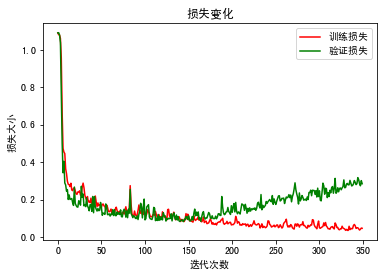

In [46]:
net = LSTM(1,3,64,2) #512,2 0.983  256,2 0.983 ,64 ,2 0.984,32,2,0.983,256,4.0.983
from time import time
if train_on_gpu:
    net.cuda()
start = time()
epochs = 350
accuracy = train(net,epochs,train_loader,valid_loader,clip=5,lr=0.00128)
print('Training time is:',time()-start,'s')

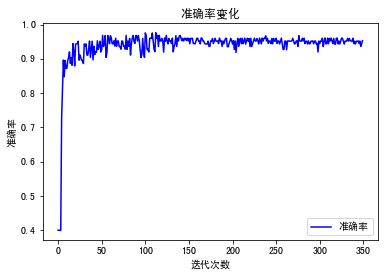

In [47]:
#plt.plot(accuracy,color='b',label='accuracy')
#plt.title('Accuracy_Trend')
#plt.xlabel('Epoches')
#plt.ylabel('Accuracy')
plt.plot(accuracy,color='b',label='准确率')
plt.title('准确率变化')
plt.xlabel('迭代次数')
plt.ylabel('准确率')
plt.legend()
plt.savefig('behavior_image/accuracy_lstm_behavior_old1.svg',dpi=300)
plt.savefig('behavior_image/accuracy_lstm_behavior_old1.png',dpi=300)

In [9]:
net_test = LSTM(1,3,64,2)
net_test.load_state_dict(torch.load('model/lstm_behavior_prediction_old.pt'))
if train_on_gpu:
    net_test.cuda()
    

test(net_test,test_loader)


Test Loss: 0.081629

Test Accuracy of left:100.0000(42/42)
Test Accuracy of keep:95.9184(47/49)
Test Accuracy of right:97.0588(33/34)
Test Accuracy(Overall):97.6000 (122/125)
Test loss: 0.063 Test Accuracy:0.9757940471172333


In [61]:
from time import time
net_test.cuda().eval()
h = net_test.init_hidden(50000)
h = tuple([each.data for each in h])
example = torch.ones(50000,4,1).cuda()
t = time()
out,h = net_test(example,h)
print('time',((time()-t)*1000)/50000)
print(out)

time 0.0007095098495483399
tensor([[-19.9564,  -0.9479,  20.0578],
        [-19.9564,  -0.9479,  20.0578],
        [-19.9564,  -0.9479,  20.0578],
        ...,
        [-19.9564,  -0.9479,  20.0578],
        [-19.9564,  -0.9479,  20.0578],
        [-19.9564,  -0.9479,  20.0578]], device='cuda:0',
       grad_fn=<SelectBackward>)
